In [1]:
import nasdaqdatalink
import os
import json
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas_market_calendars as mcal
from datetime import datetime
import requests
from refresh_functions import *
pd.options.display.float_format = '{:.6f}'.format

#modelling packages ------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC

import shap

#store my API key
with open('C:/Users/meich/.nasdaq/data_link_apikey.json') as f:
    data=json.load(f)
    key=data['api_key']
quandl.ApiConfig.api_key = key

# Data Refresh & Load
-----
Next step: schedule this code block daily in the cloud (which means having cloud storage for the data also)

In [2]:
%%time

#PRICES 
sharadarSEP()
sep = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_SEP.csv')

#TICKERS + CATEGORIES
tickers = sharadarTICKERS()

#DAILY FUNDAMENTALS
sharadarDAILY()
daily = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_DAILY.csv')
daily['marketcap_max'] = daily.groupby('ticker')['marketcap'].transform(max)
daily = daily[daily['marketcap_max']>=500]
daily['marketcap_total'] = daily.groupby('date')['marketcap'].transform(sum)

#SHORT INTEREST ACTIVITY (FINRA)
finraSHORTS()
si = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/FINRA_SI.csv')

#RETAIL TRADER ACTIVITY
nasdaqRTAT()
rtat = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/NDAQ_RTAT.csv')

Data up to date
2023-01-11
'sharadarSEP' 0.06 mins
'sharadarTICKERS' 0.50 mins
Data up to date
2023-01-11
'sharadarDAILY' 0.10 mins
Data up to date:
2023-01-11
'finraSHORTS' 0.07 mins
Data up to date:
2023-01-11
'nasdaqRTAT' 0.08 mins
Wall time: 1min 4s


### Create foundational dataset (shar)

In [3]:
combined = daily.merge(tickers,left_on='ticker',right_on='ticker',how='left')
combined = combined.merge(sep,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(rtat,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(si,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined.sort_values(['ticker','date'],inplace=True)

# Exploration/Analysis
-----

In [4]:
#ADD PRICE METRICS - logdiff 
    # rdiff 	row-on-row % change	z[t] = (y[t] – y[t-1]) / y[t-1]
    # log returns ln(stock price t1/ stock price t0)
combined = lagged_features(combined)
combined = lagged_features(combined,ft='marketcap_total')

#add price adjusted (market) target variables (closemarket_pctY vs closeadj_pctY)
combined['closemarket_pct1'] = combined['closeadj_pct1'] - combined['marketcap_total_pct1']
combined['closemarket_pct5'] = combined['closeadj_pct5'] - combined['marketcap_total_pct5']
combined['closemarket_pct30'] = combined['closeadj_pct30'] - combined['marketcap_total_pct30']
combined['closemarket_pct90'] = combined['closeadj_pct90'] - combined['marketcap_total_pct90']
combined['closemarket_pct180'] = combined['closeadj_pct180'] - combined['marketcap_total_pct180']
combined['closemarket_pct360'] = combined['closeadj_pct360'] - combined['marketcap_total_pct360']

#CREATE TARGET VARIABLES FOR A SIMPLER PROBLEM -- PREDICT IF NEW PRICE WILL BE HIGHER OR LOWER (RELATIVE TO MARKET)
combined['closemarket_pos1'] = combined['closemarket_pct1'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos5'] = combined['closemarket_pct5'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos30'] = combined['closemarket_pct30'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos90'] = combined['closemarket_pct90'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos180'] = combined['closemarket_pct180'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos360'] = combined['closemarket_pct360'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))

#CREATE TARGET VARIABLES FOR A SIMPLER PROBLEM -- PREDICT IF NEW PRICE WILL BE HIGHER OR LOWER (DISREGARDING MARKET)
combined['closeadj_pos1'] = combined['closeadj_pct1'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos5'] = combined['closeadj_pct5'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos30'] = combined['closeadj_pct30'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos90'] = combined['closeadj_pct90'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos180'] = combined['closeadj_pct180'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos360'] = combined['closeadj_pct360'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))

'lagged_features' 0.67 mins
'lagged_features' 0.71 mins


In [5]:
#SI METRICS
combined = short_features(combined)

'short_features' 0.86 mins


In [6]:
#  ---- RTAT NOTES-------#
# CHECK FOR AUTO CORRELATION IN BOTH METRICS
# TEST FOR RMSE STRATEGY OF SIMILARITY INDEX USING ACT/SENT TO PRODUCE A SINGLE SCORE FOR AGG
# SET UP ACTIVITY TRIGGER TO CATCH DAILY VALUES AND SEND NOTIFICATION + VISUAL

combined = rtat_features(combined)

'rtat_features' 0.90 mins


In [11]:
stock = combined[combined['ticker'] == 'GME'].copy()
stock = stock.sort_values(by='date')

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['closeadj_lag30'], name="price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['activity'], name="var"),
    secondary_y=True,
)

# fig.add_trace(
#     go.Scatter(x=stock['date'], y=stock['ShortRatio_30'], name="var1"),
#     secondary_y=True,
# )

fig.show()

In [12]:
#Difference between TotalVolume & activity may give insights into non-retail activity
px.scatter(combined[combined['activity']>0.1],
          'TotalVolume','activity')

### Short Term Model (Retail Activity + SI + Price Metrics + [insider / inst. investors])

In [13]:
# BUILD SIMPLE BASELINE MODEL TO PREDICT PRICE AT DIFFERENT TIME POINTS (EX: 5 DAY, 10 DAY, 20 DAY, 1 MONTH, 3 MONTH, 6 MONTH)
#       OR COULD CONSTRUCT AS A CLASSIFICATION MODEL TOO - PREDICT PROBABILITY THAT Y WILL FALL Y%

#do 'reversals' mean anything?? i.e. sentiment / sentiment_5 (or z version)

In [14]:
#px.histogram(combined[combined['ticker']== 'GME']['activity_Z'])

In [88]:
#tesla is the outlier when it comes to activty vs future price
px.scatter(combined[combined['activity']>0.05],
       x='activity',
       y='closemarket_pct90',
           trendline='ols'
      )

# Regression

This is a lot more difficult than predicting direction... and driven somewhat by outliers.. may make sense to clip or quantile bucket

In [7]:
le = preprocessing.LabelEncoder()
combined['sector_int'] = le.fit_transform(combined['sector'].astype(str))
combined['industry_int'] = le.fit_transform(combined['industry'].astype(str))

In [15]:
data = combined[combined['activity']>= 0.01 ].copy()
X_train, X_test, y_train, y_test = model_setup(
        data,
     ['activity_30','sentiment_30','ShortRatio_30','TotalVolume_30','evebitda','ps'], 
    'closemarket_pct90')

In [76]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [16]:
%%time
#fit and predict 
bst = XGBRegressor(n_estimators=1000
                   ,booster='gblinear'
                  )
bst.fit(X_train,y_train)
predictions = bst.predict(X_test)

Wall time: 288 ms


In [17]:
mean_absolute_error(y_test, predictions)

22.58841058476121

In [18]:
mean_squared_error(y_test, predictions)

1195.6970638196528

In [19]:
r2_score(y_test, predictions)

0.026832134127752427

In [20]:
X_test['preds'] = predictions
X_test['true'] = y_test

In [21]:
X_test['preds'].nunique()

2325

In [22]:
#Inspect predictions vs True Values for pct change in price
px.scatter(X_test,
          'preds',
          'true',
           color='activity_30',
          trendline='ols')

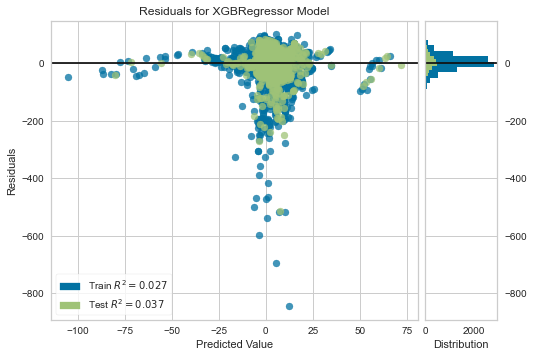

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [23]:
data = combined[combined['activity']>= 0.01 ].copy()
X_train, X_test, y_train, y_test = model_setup(
        data,
     ['activity_30','sentiment_30','ShortRatio_30','TotalVolume_30','evebitda','ps'], 
    'closemarket_pct90')

visualizer = ResidualsPlot(XGBRegressor(n_estimators=1000
                   ,booster='gblinear'
                  ))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# Classifier

as i increase the rolling timespan, accuracy goes up for 180 prediction -- is this leakage? Model actually seems good (suspicious) - 86% acc, .94 rocauc

    - pos180 vs 30(act,sent,shortratio,totalvolume)
    - when activtiy > 0.01

i bet totalvolume is having some leakage -- not standardized (dropping it does remove about 9 pts of acc)

    - see below about signaling ticker (anyone can predict the ticker from this info, not the task)

does this hold up when I use entire dataset??

When i add evebitda, acc goes wayyy up - has to be leakage (YES - bc evebitda would signal which ticker it is -- need evebitda change maybe)

    - I think the other variables may be signaling the ticker as well

In [97]:
data = combined[combined['activity']>= 0.01 ].copy()
vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15',
        'activity_5','sentiment_5','ShortRatio_5','TotalVolume_5',
        'activity','sentiment','ShortRatio','TotalVolume',
        'evebitda','ps','pb','pe','marketcap','sector_int','industry_int']
target = 'closemarket_pos5'

X_train, X_test, y_train, y_test = model_setup(
        data,
     vars, 
    target)

In [98]:
%%time
#fit and predict 
bst = XGBClassifier(n_estimators=1000,eval_metric='error',use_label_encoder=False
                  )
bst.fit(X_train,y_train)
predictions = bst.predict(X_test)
probpredictions = bst.predict_proba(X_test)[:,1]

Wall time: 5.64 s


In [99]:
y_test.mean()

0.5071283095723014

In [100]:
accuracy_score(y_test,predictions)

0.7287169042769858

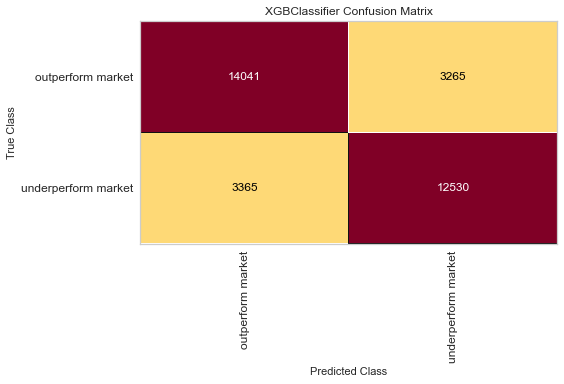

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [81]:
#show classification results in graphs
visualizer = ConfusionMatrix(XGBClassifier(n_estimators=100,eval_metric='error',use_label_encoder=False
                  ),
                            classes=['outperform market','underperform market'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

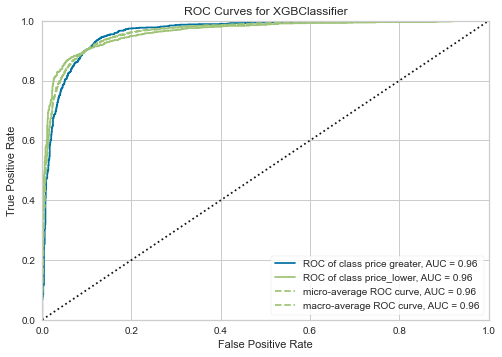

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [36]:
visualizer = ROCAUC(XGBClassifier(n_estimators=100,eval_metric='error',use_label_encoder=False
                                 ),
                   classes=['price greater','price_lower'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [37]:
X_test['preds'] = predictions
X_test['proba_preds'] = probpredictions
X_test['true'] = y_test

In [38]:
#shap values or some contribution goal
# what's a good way to look at proba preds vs true class (to see if my probabilities are legit)
X_test['ticker'] = combined['ticker']
X_test['date'] = combined['date']
X_test['market chng'] = combined['closemarket_pct180']
X_test['actual chng'] = combined['closeadj_pct180']
X_test['proba_bins'] =pd.cut(X_test['proba_preds'],10,right=False,labels=False)
X_test['correct'] = X_test['preds'] ==X_test['true']

In [39]:
# actual mean value vs each predicted probability bin - see a linear trend
px.bar(X_test.groupby('proba_bins').mean(),
       x=X_test.groupby('proba_bins').mean().index,
       color='correct',
       y='true')

In [40]:
X_test[X_test['ticker'] =='MSFT']['preds'].mean()

0.6323529411764706

In [41]:
X_test[X_test['ticker'] =='MSFT']['true'].mean()

0.625

In [43]:
# predict on newest date
newdata = combined[(combined['date'] == '2023-01-11' ) & (combined['activity']>.01)][vars]
newpreds = bst.predict(newdata)
newproba = bst.predict_proba(newdata)[:,1]

newdata['preds'] = newpreds
newdata['proba_prebs'] = newproba
newdata['ticker'] = combined['ticker']
newdata['date'] = combined['date']
newdata['activity'] = combined['activity']

newdata

activity_15  sentiment_15  ShortRatio_15   TotalVolume_15  \
5865342     0.039887     -1.200000       0.476284  37438773.333333   
5865153     0.017020     -5.000000       0.433839  27435467.400000   
5865114     0.026013     -0.666667       0.391286  32862514.866667   
5862889     0.012980     -5.266667       0.351198  10306902.400000   
5862698     0.026167     -4.000000       0.456230  22398266.733333   
5861626     0.145567     -2.733333       0.490453 111386632.200000   

         activity_5  sentiment_5  ShortRatio_5    TotalVolume_5  evebitda  \
5865342    0.036540     1.000000      0.485806  34835450.800000 16.700000   
5865153    0.017180    -1.800000      0.475773  30147976.000000 19.200000   
5865114    0.027440     1.800000      0.450571  36424699.800000 21.000000   
5862889    0.014920    -1.800000      0.380229  12296863.400000 17.000000   
5862698    0.027180    -1.000000      0.511752  23223276.800000 54.100000   
5861626    0.135180    -2.600000      0.527082 112975086.600000 23.100000   

               ps        pb        pe      marketcap  sector_int  \
5865342  5.400000 41.900000 21.300000 2123574.700000           9   
5865153  4.900000  2.000000 49.000000  111349.300000           9   
5865114  1.900000  7.100000 85.700000  970075.300000           9   
5862889  8.700000 10.100000 25.200000 1757541.100000           9   
5862698 13.800000 18.400000 66.100000  393624.600000           9   
5861626  5.200000  9.800000 34.800000  389098.300000           2   

         industry_int  preds  proba_prebs ticker        date  activity  
5865342            31      1     0.922572   AAPL  2023-01-11  0.035600  
5865153           124      0     0.034542    AMD  2023-01-11  0.015800  
5865114            75      0     0.072068   AMZN  2023-01-11  0.038500  
5862889           128      1     0.954356   MSFT  2023-01-11  0.013000  
5862698           124      0     0.223676   NVDA  2023-01-11  0.024700  
5861626            10      0     0.006514   TSLA  2023-01-11  0.140700

In [90]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

C:\Users\meich\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



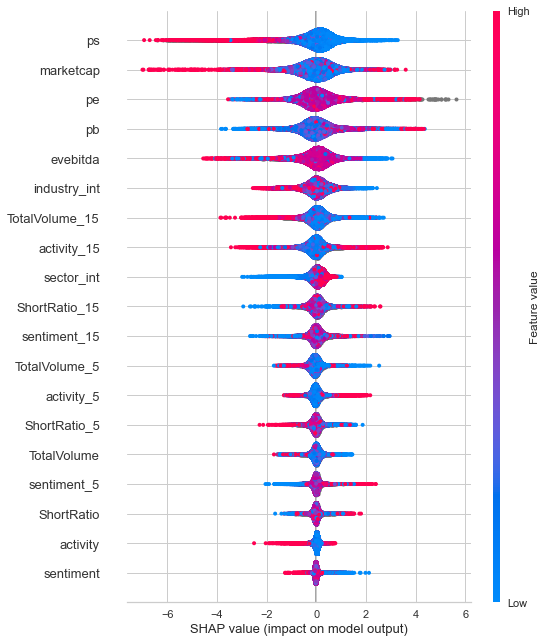

In [91]:
#CLASSIC SHAP SUMMARY PLOT
shap.summary_plot(shap_values, X_train)

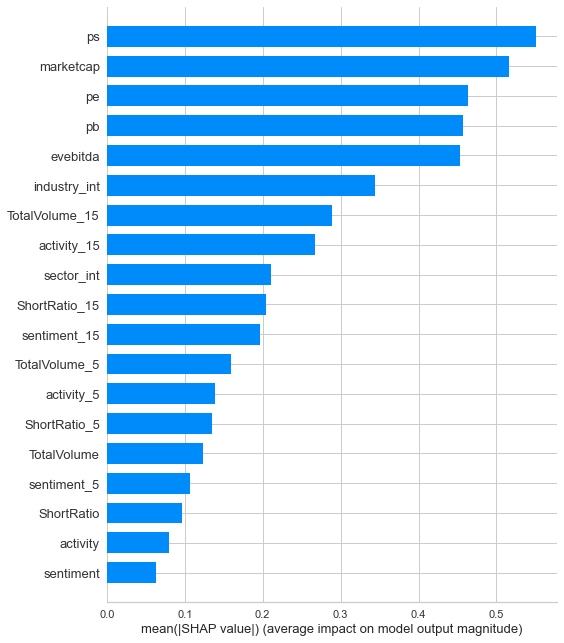

In [92]:
#SHAP FEATURE IMPORTANCE
shap.summary_plot(shap_values, X_train, plot_type="bar")

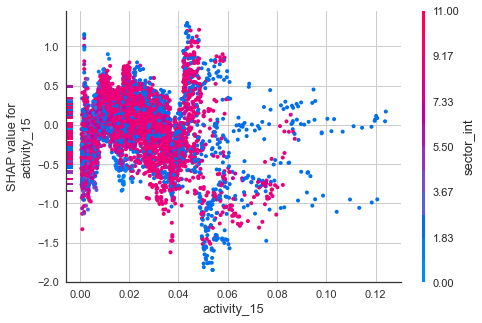

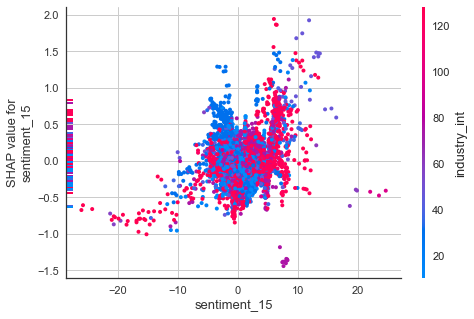

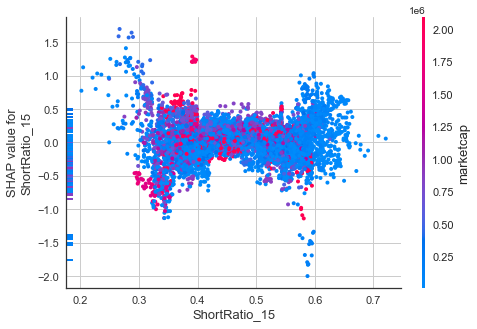

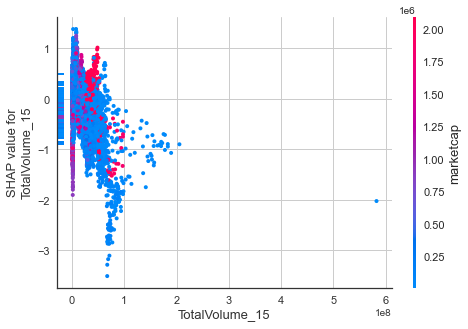

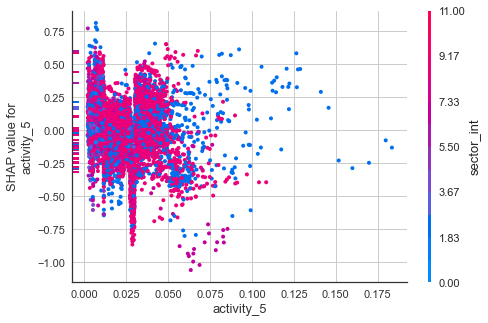

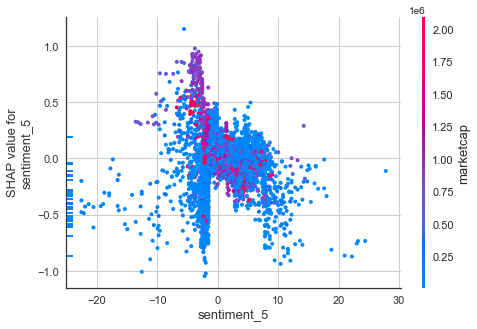

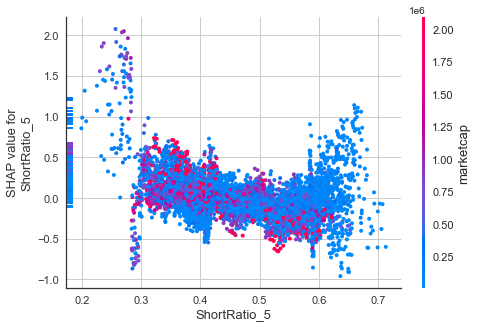

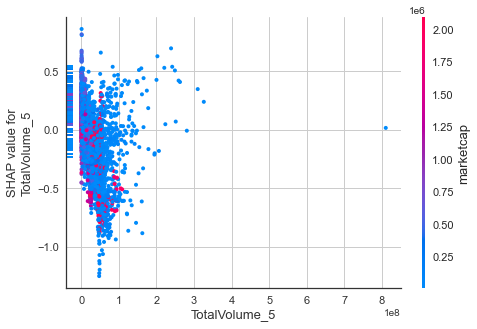

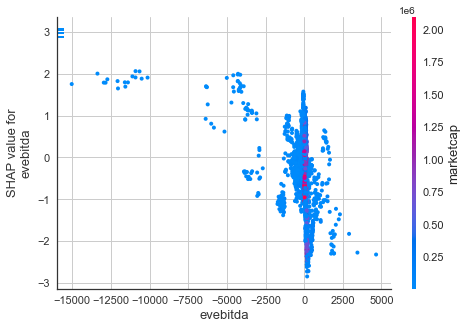

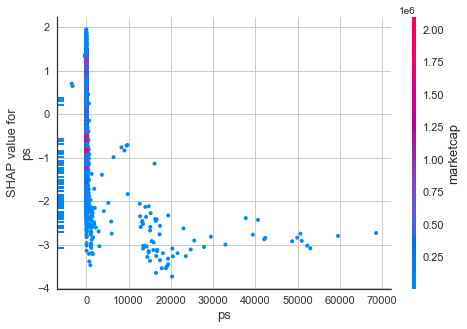

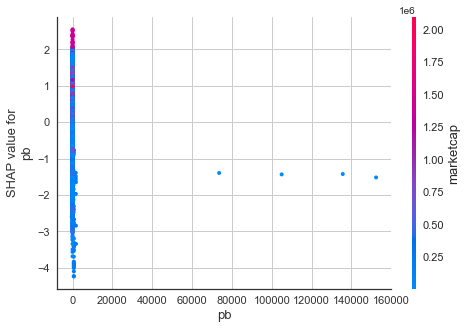

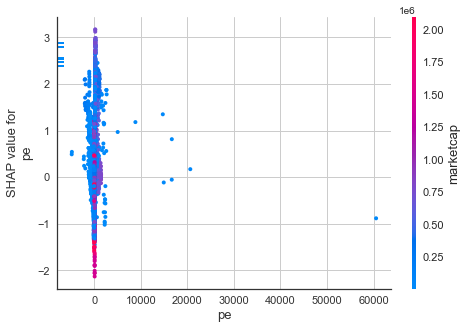

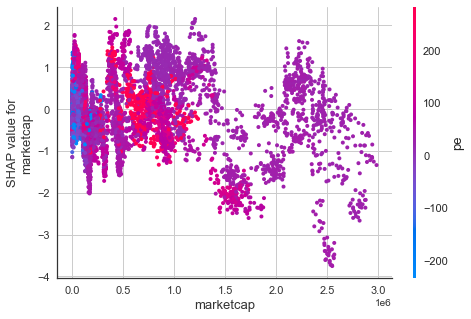

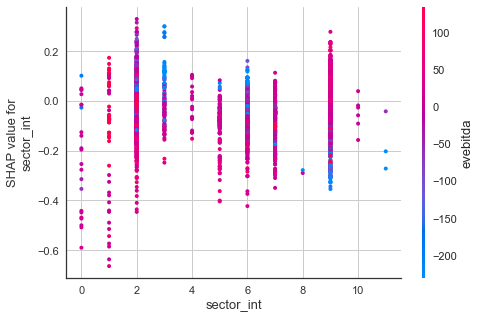

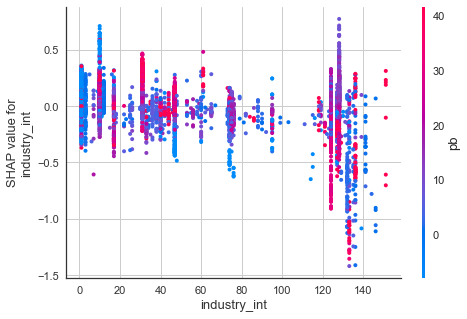

In [47]:
# INTERACTION PLOTS
for name in X_train.columns:
    shap.dependence_plot(name,shap_values,X_train)

# Multi-Classification

Idea is to bucket returns into classes